In [1]:
import os
import scipy as scp
import scipy.misc 

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import logging
import tensorflow as tf
import sys

import fcn8_vgg
import utils
from datetime import datetime

logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s',
                    level=logging.INFO,
                    stream=sys.stdout)

from tensorflow.python.framework import ops

### Set up the path to look for dataset

In [2]:
image_path = "/Volumes/JetDrive/dataset/PASCAL2010/train_val/VOC2010"
train_test_path = "/Volumes/JetDrive/dataset/PASCAL2010/PERSON_PART/pascal_person_part_trainval_list/"

In [3]:
'''
im_list: contains paths to the person images. shape:(1716,)
gt_list: contains paths to ground truth images. shape:(1716,)
The images order in two lists coresponds to each other. 
'''

im_list = []
gt_list = []
with open(train_test_path+'train.txt') as f:
    for line in f:
        im, gt = line.split(" ")
        im_list.append(im)
        gt_list.append(gt.strip())

In [52]:
"""
This part is to calculate the mean RGB values of the 
pascal person dataset.

R_mean: 113.380
G_mean: 106.204
B_mean: 98.770
"""
R,G,B = [],[],[]

for i in range(0, 1716):
    image = plt.imread(image_path+im_list[i])
    R.append(np.mean(image[:,:,0]))
    G.append(np.mean(image[:,:,1]))
    B.append(np.mean(image[:,:,2]))

R_m = np.mean(R)
G_m = np.mean(G)
B_m = np.mean(B)

In [25]:
a = tf.read_file(image_path+gt_list[121])
annotation_tensor = tf.image.decode_png(a, channels=1)
b = tf.read_file(image_path+im_list[121])
image_tensor = tf.image.decode_jpeg(b, channels=3)
#h_labels_tensor = tf.to_float(tf.equal(annotation_tensor, 38))
#t_labels_tensor = tf.to_float(tf.equal(annotation_tensor, 75))
#c = tf.concat(axis=2, values=[h_labels_tensor, t_labels_tensor])
#f = tf.reshape(tensor=c, shape=(-1,2))
uni = tf.unique(tf.reshape(annotation_tensor,[-1]))
exp = tf.expand_dims(image_tensor,axis=0)
with tf.Session() as ss:
    e1 = ss.run(exp)

In [27]:
np.shape(e1)

(1, 263, 400, 3)

In [34]:
c = image_path+im_list[19]
d = image_path+gt_list[19]
with tf.Session() as ss:
    init = tf.global_variables_initializer()
    ss.run(init)
    # d = ss.run(flat_logits,feed_dict={image_filename_placeholder:c, annotation_filename_placeholder:d})
    f = ss.run(flat_labels,feed_dict={image_filename_placeholder:c, annotation_filename_placeholder:d})

In [31]:
np.shape(d)

(1, 375, 500, 7)

In [33]:
np.shape(d)

(187500, 7)

In [35]:
np.shape(f)

(187500, 7)

### Build up the FCN model.

In [28]:
with tf.Session() as sess:
    
    vgg_fcn = fcn8_vgg.FCN8VGG()

    image_filename_placeholder = tf.placeholder(tf.string)
    annotation_filename_placeholder = tf.placeholder(tf.string)
    image_tensor = tf.read_file(image_filename_placeholder)
    annotation_tensor = tf.read_file(annotation_filename_placeholder)
    img = tf.image.decode_jpeg(image_tensor, channels=3)
    gt = tf.image.decode_png(annotation_tensor, channels=1)

    bg_label_tensor = tf.to_float(tf.equal(gt, 0, name="Background"))
    hd_label_tensor = tf.to_float(tf.equal(gt, 38, name="Head"))
    ts_label_tensor = tf.to_float(tf.equal(gt, 75, name="Tosor"))
    ua_label_tensor = tf.to_float(tf.equal(gt, 113, name="Upper_Arm"))
    la_label_tensor = tf.to_float(tf.equal(gt, 14, name="lower_Arm"))
    ul_label_tensor = tf.to_float(tf.equal(gt, 52, name="Upper_Leg"))
    ll_label_tensor = tf.to_float(tf.equal(gt, 89, name="Lower_Leg"))
    combined_mark = tf.concat(axis=2, values=[bg_label_tensor,hd_label_tensor,
                                             ts_label_tensor, ua_label_tensor,
                                             la_label_tensor, ul_label_tensor,
                                             ll_label_tensor])
    flat_labels = tf.reshape(tensor=combined_mark, shape=(-1, 7))

    img_float = tf.to_float(img)
    img_batch = tf.expand_dims(img_float, axis=0)
    vgg_fcn.build(img_batch, train=True, num_classes=7,debug=True,random_init_fc8=True)
    biased_vector = np.array((0.1,1,1,1,1,1,1))
    predition = tf.multiply(vgg_fcn.upscore32,biased_vector)

    flat_logits = tf.reshape(tensor=predition, shape=(-1, 7))
    cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                              labels=flat_labels)
    with tf.name_scope("loss"):
        loss_sum = tf.reduce_sum(cross_entropies)
        tf.summary.scalar('loss', loss_sum)

    with tf.variable_scope("adam_vars"):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_step = optimizer.minimize(loss_sum)

#     init = tf.global_variables_initializer()
#     merged = tf.summary.merge_all()
#     write = tf.summary.FileWriter("log/", sess.graph)
#     sess.run(init)

#     for epoch in range(1):
#         for i in range(0,2):
#             img_filename = image_path+im_list[i]
#             gt_filename = image_path+gt_list[i]
#             feed_dictionary = {image_filename_placeholder:img_filename,
#                                annotation_filename_placeholder:gt_filename}
#             sess.run(train_step, feed_dict=feed_dictionary)
#             if i%2 == 0:
#                 temp_loss = sess.run(loss_sum, feed_dict=feed_dictionary)
#                 print("Temporay loss: %f" % temp_loss)
#                 print("The time is %s" % str(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
                
#     filters = ['conv1_1/filter:0','conv1_1/biases:0',"conv1_2/filter:0","conv1_2/biases:0",
#                "conv2_1/filter:0","conv2_1/biases:0","conv2_2/filter:0","conv2_2/biases:0",
#                "conv3_1/filter:0","conv3_1/biases:0","conv3_2/filter:0","conv3_2/biases:0",
#                "conv4_1/filter:0","conv4_1/biases:0","conv4_2/filter:0","conv4_2/biases:0",
#                "conv4_3/filter:0","conv4_3/biases:0","conv5_1/filter:0","conv5_1/biases:0",
#                "conv5_2/filter:0","conv5_2/biases:0","conv5_3/filter:0","conv5_3/biases:0",
#                "fc6/weights:0","fc6/biases:0","fc7/weights:0","fc7/biases:0",
#                "score_fr/weights:0", "score_fr/biases:0", "upscore2/up_filter:0",
#                "score_pool4/weights:0","score_pool4/biases:0","upscore4/up_filter:0",
#                "score_pool3/weights:0","score_pool3/biases:0","upscore32/up_filter:0"]
    
#     c11w,c11b,c12w,c12b,c21w,c21b,c22w,c22b,c31w,c31b,c32w,c32b,c41w,c41b,c42w,c42b,c43w,c43b,c51w,c51b,c52w,c52b,c53w,c53b,fc6w,fc6b,fc7w,fc7b,sw,sb,up2w,s4w,s4b,up4w,s3w,s3b,up32 = sess.run(filters)
    
#     save_dict={}
#     save_dict={"conv1_1":[c11w,c11b], "conv1_2":[c12w,c12b],"conv2_1":[c21w,c21b],"conv2_2":[c22w,c22b],
#               "conv3_1":[c31w,c31b],"conv3_2":[c32w,c32b],"conv4_1":[c41w,c41b],"conv4_2":[c42w,c42b],
#               "conv4_3":[c43w,c43b],"conv5_1":[c51w,c51b],"conv5_2":[c52w,c52b],"conv5_3":[c53w,c53b],
#               "fc6":[fc6w,fc6b],"fc7":[fc7w,fc7b],"score_fr":[sw,sb], "upscore2":[up2w],
#               "score_pool4":[s4w,s4b],"upscore4":[up4w],"score_pool3":[s3w,s3b],"upscore32":[up32]}
    
#     np.save("test.npy", save_dict)
    

npy file loaded
Layer name: conv1_1
Layer shape: (3, 3, 3, 64)
Layer name: conv1_2
Layer shape: (3, 3, 64, 64)
Layer name: conv2_1
Layer shape: (3, 3, 64, 128)
Layer name: conv2_2
Layer shape: (3, 3, 128, 128)
Layer name: conv3_1
Layer shape: (3, 3, 128, 256)
Layer name: conv3_2
Layer shape: (3, 3, 256, 256)
Layer name: conv3_3
Layer shape: (3, 3, 256, 256)
Layer name: conv4_1
Layer shape: (3, 3, 256, 512)
Layer name: conv4_2
Layer shape: (3, 3, 512, 512)
Layer name: conv4_3
Layer shape: (3, 3, 512, 512)
Layer name: conv5_1
Layer shape: (3, 3, 512, 512)
Layer name: conv5_2
Layer shape: (3, 3, 512, 512)
Layer name: conv5_3
Layer shape: (3, 3, 512, 512)
Layer name: fc6
Layer shape: [7, 7, 512, 4096]
Layer name: fc7
Layer shape: [1, 1, 4096, 4096]


In [28]:
var

[u'conv1_1/filter:0',
 u'conv1_1/biases:0',
 u'conv1_2/filter:0',
 u'conv1_2/biases:0',
 u'conv2_1/filter:0',
 u'conv2_1/biases:0',
 u'conv2_2/filter:0',
 u'conv2_2/biases:0',
 u'conv3_1/filter:0',
 u'conv3_1/biases:0',
 u'conv3_2/filter:0',
 u'conv3_2/biases:0',
 u'conv3_3/filter:0',
 u'conv3_3/biases:0',
 u'conv4_1/filter:0',
 u'conv4_1/biases:0',
 u'conv4_2/filter:0',
 u'conv4_2/biases:0',
 u'conv4_3/filter:0',
 u'conv4_3/biases:0',
 u'conv5_1/filter:0',
 u'conv5_1/biases:0',
 u'conv5_2/filter:0',
 u'conv5_2/biases:0',
 u'conv5_3/filter:0',
 u'conv5_3/biases:0',
 u'fc6/weights:0',
 u'fc6/biases:0',
 u'fc7/weights:0',
 u'fc7/biases:0',
 u'score_fr/weights:0',
 u'score_fr/biases:0',
 u'upscore2/up_filter:0',
 u'score_pool4/weights:0',
 u'score_pool4/biases:0',
 u'upscore4/up_filter:0',
 u'score_pool3/weights:0',
 u'score_pool3/biases:0',
 u'upscore32/up_filter:0']

In [19]:
var = [v.name for v in tf.trainable_variables()]

In [27]:
with tf.Session() as s:
    e = s.run("conv1_1/filter:0")

FailedPreconditionError: Attempting to use uninitialized value conv1_1/filter
	 [[Node: _send_conv1_1/filter_0 = _Send[T=DT_FLOAT, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=9089117610572213901, tensor_name="conv1_1/filter:0", _device="/job:localhost/replica:0/task:0/cpu:0"](conv1_1/filter)]]

In [ ]:
np.shape(e)

In [21]:
e

<tf.Operation 'conv5_3/Relu' type=Relu>

### To restore the network.

In [2]:
w1 = tf.Variable(tf.truncated_normal(shape=[10]), name='w1')
w2 = tf.Variable(tf.truncated_normal(shape=[20]), name='w2')
tf.add_to_collection('vars', w1)
tf.add_to_collection('vars', w2)
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, '/Users/Bato/Study/COMPUTER_VISION/ICCV2017_second_idea/LSTM/tensor_lstm/model/test-model')

'/Users/Bato/Study/COMPUTER_VISION/ICCV2017_second_idea/LSTM/tensor_lstm/model/test-model'

In [2]:
sess = tf.Session()
new_saver = tf.train.import_meta_graph('model/test-model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./model/'))
all_vars = tf.get_collection('vars')
for v in all_vars:
    v_ = sess.run(v)
    print(v_)

[-1.58127618 -0.27413431  0.48931956 -0.96271074  0.3837184  -0.97886246
 -1.16651976  0.81927347  1.71385121  0.17344235]
[ 0.78186834  0.12208813 -0.58766991  0.75227284 -0.24616119 -0.75523335
 -0.2062182   0.48446772  0.84245372 -1.58937085  0.59701455  0.52455449
 -0.08243828  0.6777364  -0.1226028  -0.21110013 -0.29992312  0.82548738
 -1.94615781 -0.88360888]


In [5]:
a = tf.get_collection('vars')

In [8]:
for i in a:
    t = sess.run(i)
    print(t)

[-1.58127618 -0.27413431  0.48931956 -0.96271074  0.3837184  -0.97886246
 -1.16651976  0.81927347  1.71385121  0.17344235]
[ 0.78186834  0.12208813 -0.58766991  0.75227284 -0.24616119 -0.75523335
 -0.2062182   0.48446772  0.84245372 -1.58937085  0.59701455  0.52455449
 -0.08243828  0.6777364  -0.1226028  -0.21110013 -0.29992312  0.82548738
 -1.94615781 -0.88360888]


In [40]:
import numpy as np
a = np.load("confidence_map/2008_000041.npy")
a_gt = plt.imread("/Volumes/JetDrive/dataset/PASCAL2010/PERSON_PART/pascal_person_part_gt/2008_000041.png")

In [66]:
np.shape(a)

(1, 375, 500, 7)

In [71]:
from skimage.transform import resize,rescale

In [75]:
a[0]

array([[[  2.95257521e+00,  -1.01677036e+00,  -9.43138599e-01, ...,
          -1.92767179e+00,  -1.07486379e+00,  -1.11536980e+00],
        [  3.38953042e+00,  -1.15910411e+00,  -1.08364034e+00, ...,
          -2.22002435e+00,  -1.23903334e+00,  -1.28593516e+00],
        [  3.70374846e+00,  -1.23785651e+00,  -1.15866458e+00, ...,
          -2.36865520e+00,  -1.30980992e+00,  -1.35281181e+00],
        ..., 
        [  4.44513607e+00,  -1.53397822e+00,  -1.19428444e+00, ...,
          -1.45108497e+00,  -1.02473283e+00,  -1.29490912e+00],
        [  4.11794662e+00,  -1.39619744e+00,  -1.10959852e+00, ...,
          -1.34094620e+00,  -9.41393673e-01,  -1.19909692e+00],
        [  3.59963870e+00,  -1.23255849e+00,  -9.78140354e-01, ...,
          -1.17001128e+00,  -8.26134264e-01,  -1.04186654e+00]],

       [[  3.58206344e+00,  -1.21878004e+00,  -1.14556623e+00, ...,
          -2.34990454e+00,  -1.30946004e+00,  -1.36491323e+00],
        [  4.11839533e+00,  -1.39374745e+00,  -1.31780469e+0

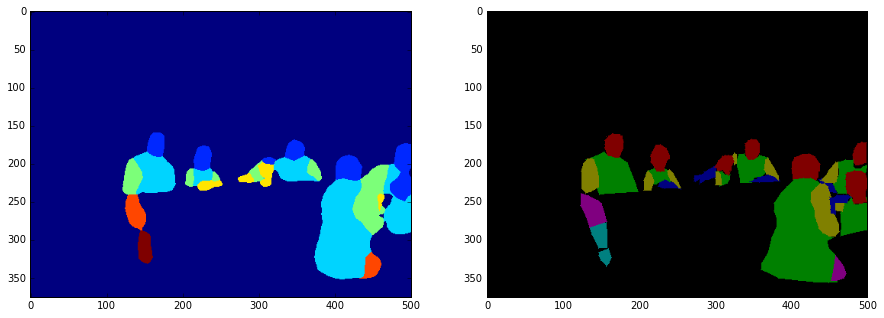

In [42]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(np.argmax(a[0,:,:,:], axis=2))
plt.subplot(122)
plt.imshow(a_gt)

In [2]:
b = np.load("confidence_map/2008_000008.npy")
b_gt = plt.imread("/Volumes/JetDrive/dataset/PASCAL2010/PERSON_PART/pascal_person_part_gt/2008_000008.png")

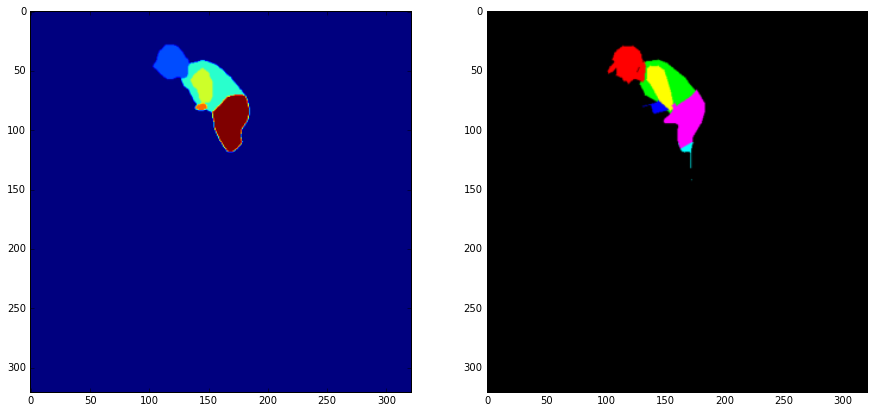

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(scipy.misc.imresize(np.argmax(b[0,:,:,:], axis=2), [321,321]))
plt.subplot(122)
plt.imshow(scipy.misc.imresize(b_gt, [321,321]))

In [46]:
c = np.load("confidence_map/2008_000036.npy")
c_gt = plt.imread("/Volumes/JetDrive/dataset/PASCAL2010/PERSON_PART/pascal_person_part_gt/2008_000036.png")

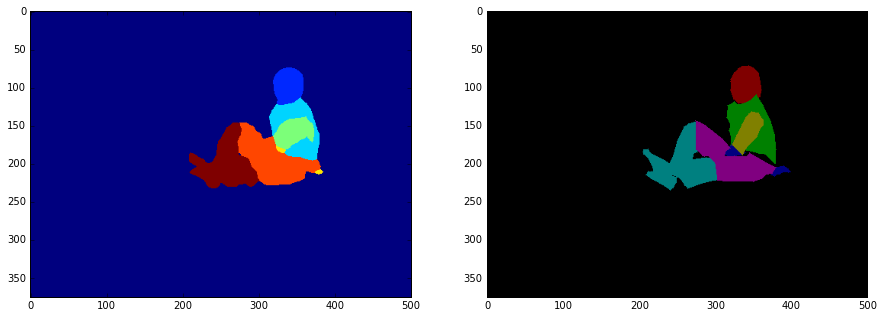

In [47]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(np.argmax(c[0,:,:,:], axis=2))
plt.subplot(122)
plt.imshow(c_gt)

In [56]:
d = b[0,:,:,:]
s = d[:,:,1].shape